In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
n_layers = 1
n_train =2500
n_test = 1000

SAVE_PATH = "/content/gdrive/My Drive/QIP/emnist/quanvolution_train_mini2/"
PREPROCESS = False
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:

train = pd.read_csv('/content/gdrive/My Drive/QIP/emnist/emnist-letters-train.csv')


In [ ]:
print('training dataset dimensions: ', train.shape)


training dataset dimensions:  (88799, 785)


In [ ]:
columns = ['labels']
for i in range(train.shape[1]-1):
    columns.append(i)

train.columns = columns
print("col", columns)
classes = sorted(train['labels'].unique())
print('number of classes: ', len(classes))
print("classes", classes)

col ['labels', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train.drop(['labels'], axis=1),
                                                  train.labels - 1,
                                                  train_size=2500,
                                                  test_size=1000,
                                                  random_state=0,
                                                  stratify=train.labels - 1)

x_train = x_train / 255.0
x_val = x_val / 255.0

x_train = x_train.values.reshape(x_train.shape[0],28, 28, 1).astype('float32')
x_val = x_val.values.reshape(x_val.shape[0],28, 28, 1).astype('float32')

print('trianing set: ', x_train.shape, y_train.shape)
print('validation set: ', x_val.shape, y_val.shape)
type(x_train)

trianing set:  (2500, 28, 28, 1) (2500,)
validation set:  (1000, 28, 28, 1) (1000,)


numpy.ndarray

In [ ]:
dev = qml.device('qiskit.ibmq', wires=4, backend='ibmq_qasm_simulator', ibmqx_token="1d30263a2656825b899d953e66f24560a5805c19db74fbcf942161ccdb5ecc066fb7438e77eed4e1bb8665d5e71d2c38b56547f52338fa7c9236b65318079977")
dev.capabilities()['backend']
#dev = qml.device("default.qubit", wires=4)
#dev = qml.device("qiskit.aer", wires=4)

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)

    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
print(rand_params)

[[3.44829694 4.49366732 3.78727399 3.42360201]]


In [ ]:
drawer = qml.draw(circuit, show_all_wires=True)
print(drawer(rand_params[0]))

0: ──RX(10.83)─╭RandomLayers(M0)─┤  <Z>
1: ──RX(14.12)─├RandomLayers(M0)─┤  <Z>
2: ──RX(11.90)─├RandomLayers(M0)─┤  <Z>
3: ──RX(10.76)─╰RandomLayers(M0)─┤  <Z>


In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        print(idx + 1, "/", x_train.shape[0])
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_val):
        print(idx + 1, "/", x_val.shape[0])
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

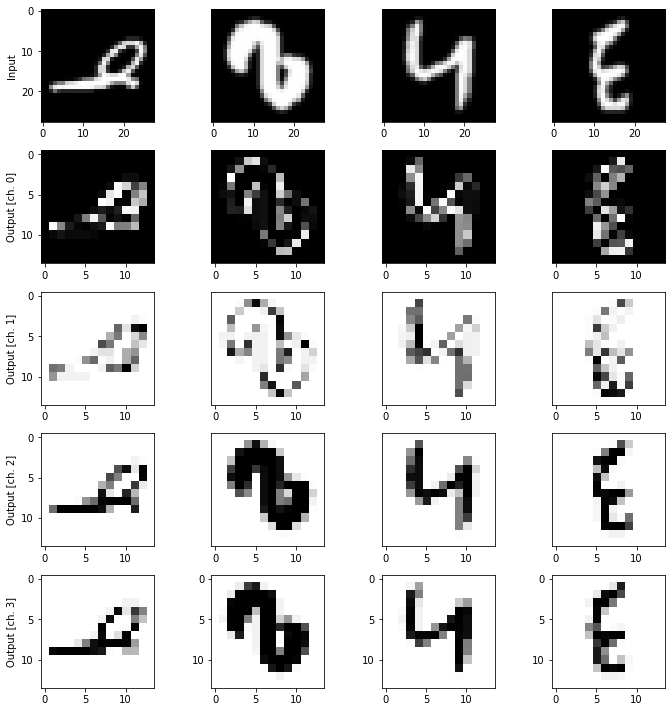

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")
    #plt.title(np.argmax(y_predict))

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


In [ ]:
from keras import regularizers
from keras import backend as K

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32,2,input_shape=(14,14,4)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Flatten(),
        keras.layers.Dense(250, activation="relu", kernel_regularizer=regularizers.l2(0.000001), bias_regularizer=regularizers.L2(0.00005)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.000001), bias_regularizer=regularizers.L2(0.00005)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(26, activation="softmax")

    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    K.set_value(model.optimizer.learning_rate, 0.0005)
    return model

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=8,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=8,factor=0.2,min_lr=0.001)

In [ ]:

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y_train,
    validation_data=(q_test_images, y_val),
    epochs=60,
    verbose=2,
    callbacks=[MCP,ES,RLP]
)

q_model.summary()

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.45800, saving model to Best_points.h5
79/79 - 14s - loss: 2.8545 - accuracy: 0.1880 - val_loss: 2.0683 - val_accuracy: 0.4580 - lr: 5.0000e-04 - 14s/epoch - 178ms/step
Epoch 2/60

Epoch 2: val_accuracy improved from 0.45800 to 0.60400, saving model to Best_points.h5
79/79 - 0s - loss: 1.9699 - accuracy: 0.4176 - val_loss: 1.4606 - val_accuracy: 0.6040 - lr: 5.0000e-04 - 340ms/epoch - 4ms/step
Epoch 3/60

Epoch 3: val_accuracy improved from 0.60400 to 0.66400, saving model to Best_points.h5
79/79 - 0s - loss: 1.5174 - accuracy: 0.5420 - val_loss: 1.2375 - val_accuracy: 0.6640 - lr: 5.0000e-04 - 320ms/epoch - 4ms/step
Epoch 4/60

Epoch 4: val_accuracy improved from 0.66400 to 0.67500, saving model to Best_points.h5
79/79 - 0s - loss: 1.2710 - accuracy: 0.6064 - val_loss: 1.0819 - val_accuracy: 0.6750 - lr: 5.0000e-04 - 406ms/epoch - 5ms/step
Epoch 5/60

Epoch 5: val_accuracy improved from 0.67500 to 0.70700, saving model to Best_p

In [ ]:
q_model.save(SAVE_PATH + "q_model")

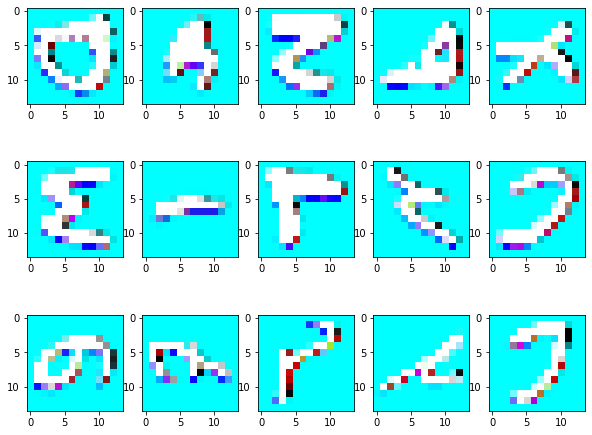

In [ ]:
import matplotlib.pyplot as plt 
import warnings
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(q_test_images[i], cmap="gray")


In [ ]:
axes[0, 1].imshow(x_train[1, :, :, 0], cmap="gray")
plt.show()

In [ ]:
labels_dict ={1:'A',2:'B',3:'C',4:'D',5:'E',6:'F',7:'G',8:'H',9:'I',10:'J',11:'K',12:'L',13:'M',14:'N',15:'O',16:'P',17:'Q',18:'R',19:'S',20:'T',21:'U',22:'V',23:'W',24:'X',25:'Y',26:'Z'}

In [ ]:
def predictShow(i):
  prediction=q_model.predict(q_test_images[i:i+1])
  y_predict=(prediction>0.5)
  plt.imshow(q_train_images[i],cmap="gray")
  plt.title(labels_dict[np.argmax(y_predict)])
  plt.show()

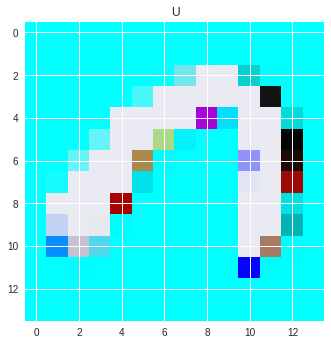

In [ ]:
predictShow(34)

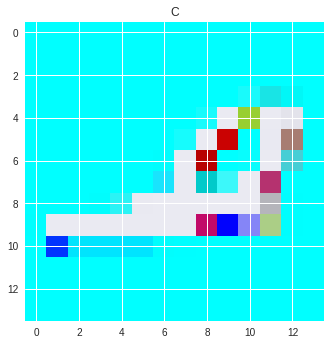

In [ ]:
predictShow(0)

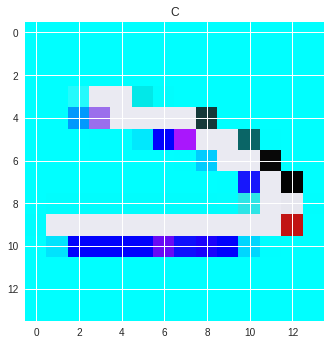

In [ ]:
predictShow(100)

In [ ]:
def plotgraph(epochs, acc, val_acc, type):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model ' + type)
    plt.ylabel(type)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = q_history.history['accuracy']
val_acc = q_history.history['val_accuracy']
loss = q_history.history['loss']
val_loss = q_history.history['val_loss']
epochs = range(1,len(acc)+1)

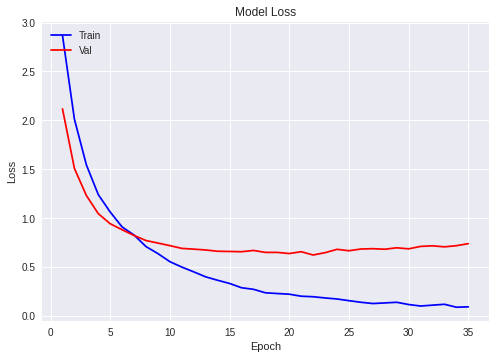

In [ ]:
plotgraph(epochs, loss, val_loss, 'Loss')

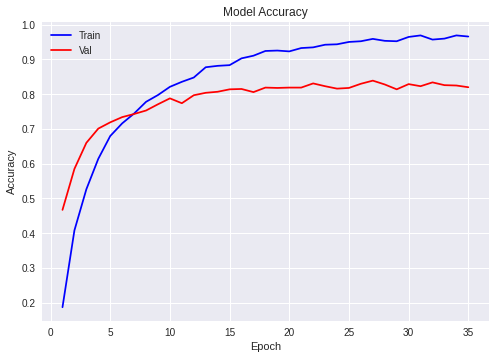

In [ ]:
plotgraph(epochs, acc, val_acc, 'Accuracy')

In [ ]:
from keras import regularizers
from keras import backend as K

def MyModel_classical():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32,2,input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Flatten(),
        keras.layers.Dense(250, activation="relu", kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.L2(0.00005)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.L2(0.00005)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(26, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    K.set_value(model.optimizer.learning_rate, 0.0001)
    return model

In [ ]:
c_model = MyModel_classical()

c_history = c_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=35,
    verbose=2,
    #callbacks=[MCP,ES,RLP]
)

c_model.summary()

Epoch 1/35
79/79 - 1s - loss: 3.1994 - accuracy: 0.1516 - val_loss: 2.9715 - val_accuracy: 0.3580 - 999ms/epoch - 13ms/step
Epoch 2/35
79/79 - 0s - loss: 2.7878 - accuracy: 0.2840 - val_loss: 2.4451 - val_accuracy: 0.4610 - 287ms/epoch - 4ms/step
Epoch 3/35
79/79 - 0s - loss: 2.3727 - accuracy: 0.3800 - val_loss: 2.0313 - val_accuracy: 0.5280 - 294ms/epoch - 4ms/step
Epoch 4/35
79/79 - 0s - loss: 2.0559 - accuracy: 0.4392 - val_loss: 1.7760 - val_accuracy: 0.5590 - 296ms/epoch - 4ms/step
Epoch 5/35
79/79 - 0s - loss: 1.8225 - accuracy: 0.5064 - val_loss: 1.6044 - val_accuracy: 0.5890 - 287ms/epoch - 4ms/step
Epoch 6/35
79/79 - 0s - loss: 1.7054 - accuracy: 0.5244 - val_loss: 1.4902 - val_accuracy: 0.6210 - 286ms/epoch - 4ms/step
Epoch 7/35
79/79 - 0s - loss: 1.5778 - accuracy: 0.5592 - val_loss: 1.4213 - val_accuracy: 0.6200 - 375ms/epoch - 5ms/step
Epoch 8/35
79/79 - 0s - loss: 1.4828 - accuracy: 0.5980 - val_loss: 1.3431 - val_accuracy: 0.6390 - 292ms/epoch - 4ms/step
Epoch 9/35
79/7

In [ ]:
c_model.save(SAVE_PATH + "c_model")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/QIP/emnist/quanvolution_train_mini2/c_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/QIP/emnist/quanvolution_train_mini2/c_model/assets


In [ ]:
prediction = c_model.predict(x_train[:1])
classes_x=np.argmax(prediction,axis=1)
print(classes_x)

[3]


In [ ]:
c_acc = c_history.history['accuracy']
c_val_acc = c_history.history['val_accuracy']
c_loss = c_history.history['loss']
c_val_loss = c_history.history['val_loss']
epochs = range(1,len(c_acc)+1)

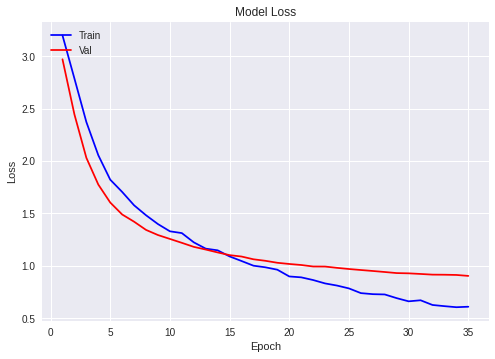

In [ ]:
plotgraph(epochs, c_loss, c_val_loss, "Loss")

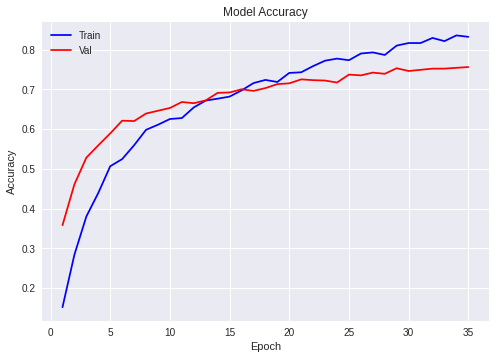

In [ ]:
plotgraph(epochs, c_acc, c_val_acc, "Accuracy")

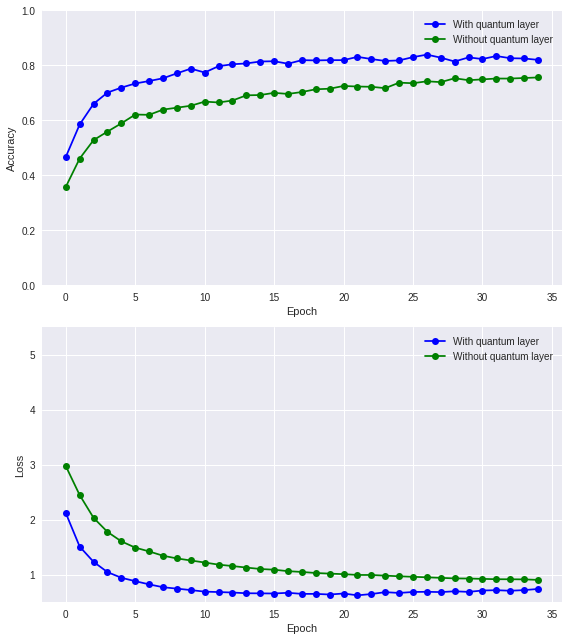

accuracy difference: 0.06400001049041748
loss difference: 0.1649227738380432


In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=5.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
print("accuracy difference:", q_history.history["val_accuracy"][-1] - c_history.history["val_accuracy"][-1])
print("loss difference:", c_history.history["val_loss"][-1] - q_history.history["val_loss"][-1])

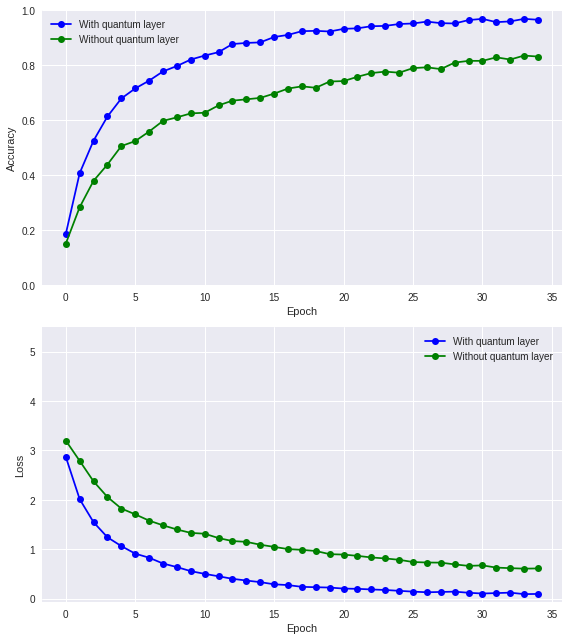

accuracy difference: 0.1340000033378601
loss difference: 0.5167160034179688


In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9))

ax1.plot(q_history.history["accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=5.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
print("accuracy difference:", q_history.history["accuracy"][-1] - c_history.history["accuracy"][-1])
print("loss difference:", c_history.history["loss"][-1] - q_history.history["loss"][-1])